Notebook used to play with visualisations, graphs, results of experiments, etc.

In [1]:
import os
import sys
import importlib
import random
import itertools

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from nltk.translate.bleu_score import sentence_bleu
from transformers import GPT2LMHeadModel, GPT2Tokenizer, PreTrainedModel

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

from src.config import set_cfg, cfg
from src.run import get_model, get_tokenizer
from src.tm_metric import compute_metric
from src.generate import predict_single_mod
from src.dataset import get_validation_data

from src.generate import encode, predict_single_mod
import src.diverse_beam_search as mbs



base_path = 'output/clai2/'

Setting bashlex grammar using file: /home/jaron/shared/internship-jaron/bashlint/grammar/grammar100.txt
Bashlint grammar set up (148 utilities)



In [2]:
# read the content of a file in a certain run folder
def readfile(file, run=""):
    path = base_path + run + '/' + file
    with open(path, 'r') as f:
        return f.read()

# load data of the all runs in base_bath
def get_runs():
    runs = []
    for i, folder in enumerate(os.listdir(base_path)):
        conf = eval(readfile('conf.txt', folder))
        conf['name'] = folder
        runs.append(conf)
        
    runs = sorted(runs, key=lambda x: x['name'])
    good_runs = []
    avg_metric = []
    for run in runs:
        try:
            metric = readfile('metric.txt', run['name'])
        except:
            # if the run is started but did not complete a complete epoch,
            # there will be no validation data an hence no metric file.
            # we can safely discard there runs
            continue
            
        metric = metric.split("\n")
        metric = [[eval(x) for x in entry[1:-1].split(',') if x] for entry in metric if entry]
        avg = [np.mean(x) for x in metric]
        avg_metric.append(avg)
        good_runs.append(run)
    return good_runs, np.array(avg_metric)


In [3]:
# functions used to filter runs by constraints on the hyperparameters

def has_constraint(run, constr):
    for k, v in constr.items():
        if k not in run.keys():
            continue
        if run[k] != v:
            return False
    return True

def avg_under(constr):
    ind = [i for i, run in enumerate(runs) 
               if has_constraint(run, constr)]
    print(ind)
    solutions = np.mean([metric_averages[i] for i in ind], axis=0)
    return solutions

for run in get_runs()[0]:
    print(run['name'])

11-10_19:16:57
11-10_20:34:01
11-10_21:52:38
11-11_08:30:35
11-11_09:43:49
11-11_13:22:03
11-11_15:41:17
11-11_18:58:45
11-12_17:06:02
prometheus
small_icarus


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Graphs

[0]
[1, 4]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


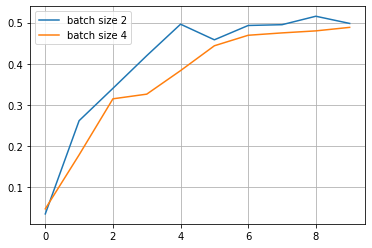

In [4]:
# batch sizes
runs, metric_averages = get_runs()
blocked_2b = avg_under({'encoding': 'blocked', 'epochs':10, 'model':'gpt2', 'max_block':200, 'batch_size':2})
blocked_4b = avg_under({'encoding': 'blocked', 'epochs':10, 'model':'gpt2', 'max_block':200, 'batch_size':4})

plt.plot(blocked_2b, label='batch size 2')
plt.plot(blocked_4b, label='batch size 4')
plt.grid()
plt.legend()

[1, 4]
[3]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


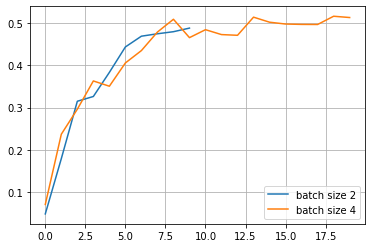

In [5]:
# epochs
runs, metric_averages = get_runs()
blocked_10e = avg_under({'encoding': 'blocked', 'epochs':10, 'model':'gpt2', 'max_block':200, 'batch_size':4})
blocked_20e = avg_under({'encoding': 'blocked', 'epochs':20, 'model':'gpt2', 'max_block':200, 'batch_size':4})


plt.plot(blocked_10e, label='batch size 2')
plt.plot(blocked_20e, label='batch size 4')
plt.grid()
plt.legend()

[3]
[2]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


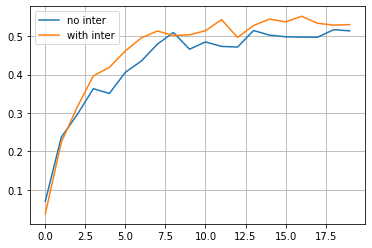

In [6]:
# interleaving
runs, metric_averages = get_runs()
blocked = avg_under({'encoding': 'blocked', 'epochs':20, 'model':'gpt2', 'max_block':200, 'batch_size':4})
blocked_inter = avg_under({'encoding': 'inter_blocked', 'epochs':20, 'model':'gpt2', 'max_block':200, 'batch_size':4})


plt.plot(blocked, label='no inter')
plt.plot(blocked_inter, label='with inter')
plt.grid()
plt.legend()

[6]
[7]
[8]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


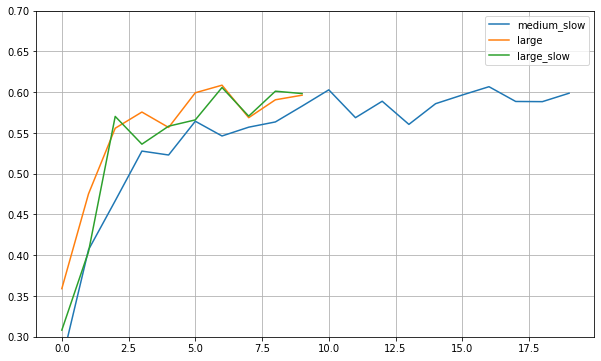

In [7]:
# model size
runs, metric_averages = get_runs()
#small = avg_under({'encoding': 'blocked', 'epochs':20, 'model':'gpt2', 'max_block':200, 'batch_size':4})
#medium = avg_under({'encoding': 'inter_blocked', 'epochs':20, 'model':'gpt2-medium', 'max_block':200, 'batch_size':2, 'grad_acc':2})
medium_slow = avg_under({'encoding': 'inter_blocked', 'epochs':20, 'model':'gpt2-medium', 'max_block':200, 'batch_size':2, 'grad_acc':4})
large = avg_under({'encoding': 'inter_blocked', 'epochs':10, 'model':'gpt2-large', 'max_block':200, 'batch_size':16, 'grad_acc':1})
large_slow = avg_under({'encoding': 'inter_blocked', 'epochs':10, 'model':'gpt2-large', 'max_block':200, 'batch_size':2, 'grad_acc':16})


plt.figure(figsize=(10, 6))
#plt.plot(small, label='small')
#plt.plot(medium, label='medium')
plt.plot(medium_slow, label='medium_slow')
plt.plot(large, label='large')
plt.plot(large_slow, label='large_slow')
plt.ylim((0.30, 0.7))


plt.grid()
plt.legend()

# Generation comparison

In [4]:
def load_run(i):
    run = get_runs()[0][i]
    print(run)
    set_cfg(run)
    set_cfg('device', 'cuda')
    tokenizer = get_tokenizer()
    model = get_model(tokenizer, resume=True)
    model.eval()
    return model, tokenizer

mod_m, tok_m = load_run(8)
mod_l, tok_l = load_run(-2)
dev_nls, dev_cms = get_validation_data()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


{'sep1': 'english:', 'sep2': 'bash:', 'encoding': 'inter_blocked', 'max_line': 170, 'max_block': 200, 'data_path': 'data/clai/', 'eos': '<|endoftext|>', 'model': 'gpt2-large', 'device': 'cpu', 'epochs': 10, 'batch_size': 2, 'grad_acc': 16, 'out_path': 'output/clai2/', 'val_metric': 'template', 'beams': 5, 'val_n': 5, 'max_gen': 200, 'add_tokens': False, 'random_init': False, 'name': '11-12_17:06:02'}


Using pad_token, but it is not set yet.


EOS <|endoftext|> 50256
PAD <|endoftext|> 50256
{'sep1': 'english:', 'sep2': 'bash:', 'encoding': 'blocked', 'max_line': 170, 'max_block': 150, 'data_path': 'data/clai/', 'eos': '<|endoftext|>', 'model': 'gpt2-medium', 'device': 'cuda', 'val_n': None, 'epochs': 40, 'batch_size': 4, 'grad_acc': 2, 'out_path': 'output/clai2/', 'beams': 2, 'max_gen': 200, 'add_tokens': False, 'random_init': False, 'name': 'prometheus'}


Using pad_token, but it is not set yet.


EOS <|endoftext|> 50256
PAD <|endoftext|> 50256


In [5]:
def get_template_score(dev_cm, pred_cms, confs):
    PARAMS = {'u1': 1., 'u2':1.}
    scores = [compute_metric(pred_cm, conf, dev_cm, PARAMS)
                for pred_cm, conf in zip(pred_cms, confs)]

    if any(x > 0 for x in scores):
        total_score = max(scores)
    else:
        total_score = sum(scores) / len(scores)
    return total_score

def second_opinion(model, tokenizer, query, result):
    query_len = len(tokenizer.encode(encode(query)))
    prompt = encode(query)+" "+result+'\n'
    tokens = tokenizer.encode(prompt, return_tensors='pt')
    tokens = tokens.to(cfg('device'))
    s = []
    for i in range(query_len, tokens.numel()):
        output = model(tokens[:,:i])
        next_token = tokens[:,i].item()
        next_prob = output[0][:, -1, :].cpu().detach()
        next_prob = torch.nn.functional.log_softmax(next_prob, dim=-1).squeeze()
        s.append(torch.exp(next_prob[next_token]).item())
    return np.mean(s)

def make_predictions(model1, model2, tokenizer1, tokenizer2, dev_nls, result_cnt=5):
    predictions1, predictions2 = [], []
    for invocation in dev_nls:
        p1 = predict_single_mod(model1, tokenizer1, invocation, top=2*result_cnt)
        p2 = predict_single_mod(model2, tokenizer2, invocation, top=2*result_cnt)
        predictions1.append(p1)
        predictions2.append(p2)
    return predictions1, predictions2
    

p1, p2 = make_predictions(mod_m, mod_l, tok_m, tok_l, dev_nls)


In [6]:
PARAMS = {'u1': 1., 'u2':1.}

with open('data/pred/dev_nl.txt', 'w+') as f_nl:
    with open('data/pred/dev_cm.txt', 'w+') as f_cm:
        with open('data/pred/dev_sc.txt', 'w+') as f_sc:
            for pp1, pp2, dev_nl, dev_cm in zip(p1, p2, dev_nls, dev_cms):
                for p in pp1[0] + pp2[0]:
                    print(dev_nl, file=f_nl)
                    #print(dev_cm[0], file=f_cm)
                    print(p, file=f_cm)
                    s = compute_metric(p, 1, dev_cm[0], PARAMS)
                    print(s, file=f_sc)


In [8]:
def word_simil(refr, new, norm=False):
    #print(new)
    new = set(new.split(' '))
    #print(refr)
    refr = [set(x.split(' ')) for x in refr if x!=new]
    if norm:
        refr = [len(new&x)/max(len(x), len(new)) for x in refr]
    else:
        refr = [len(new&x) for x in refr]
    #print(refr, np.mean(refr))    
    if norm:
        return np.mean(refr)
    else:
        return max(refr)

def template_simil(refr, new):
    #print()
    bscore = -1
    #print("NEW", new)
    for x in refr:
        if x == new: continue
        #print(x)
        score = get_template_score(new, [x], [1.])
        #print(score)
        bscore = max(score, bscore)
    return bscore

def best_subset(ps, n):
    best_loss = float('+inf')
    best_ss = None
    for ss in itertools.combinations(list(ps), n):
        ss_loss = sum(word_simil(ss, x, False) for x in ss)
        if ss_loss < best_loss:
            best_loss = ss_loss
            best_ss = ss
    return set(ss)


def get_equal_pairs(combi):
    fpairs = dict()
    combi = list(combi)
    for p in combi:
        fpairs[p] = {p}
    for i in range(len(combi)):
        pi = combi[i]
        for j in range(i+1, len(combi)):
            pj = combi[j]
            score = compute_metric(pi, 1, pj, PARAMS)
            if score >= 0.8:
                fpairs[pi] = {pj}
                fpairs[pj].add(pi)
    return fpairs


def combiner_moderna(p1, p2, result_cnt=5):
    if len(p1&p2) == 0:
        ins = {max(p1|p2, key=lambda x: word_simil(p1|p2, x))}
    else:
        ins = p1 & p2
    
    fpairs = get_equal_pairs(ins)
    fpairs = {frozenset(v) for k,v in fpairs.items()}
    for pair in fpairs:
        best = min(ins, key=lambda x: word_simil(ins, x))
        for pp in fpairs - {best}:
            ins.discard(pp)
    
    
    while len(ins) > result_cnt -1:
        # too much agreement: remove most similar
        best = max(ins, key=lambda x: word_simil(ins, x))
        ins.remove(best)
            
    overig = (p1 | p2) - ins
    fpairs = get_equal_pairs(overig)
    while len(ins) < result_cnt and len(overig) > 0:
        # not enough agreement: add diverse commands
        best = min(overig, key=lambda x: word_simil(ins, x))
        ins.add(best)
        overig.remove(best)
        for pp in fpairs[best]:
            overig.discard(pp)
    
    preds = list(ins)
    confs = [1.]*len(preds)
    while len(preds) < result_cnt:
        preds.append('date')
        confs.append(0.)
    return list(ins), [1.]*5

def combiner_mix(p1, p2, result_cnt=5):
    if len(p1&p2) == 0:
        ins = {max(p1|p2, key=lambda x: word_simil(p1|p2, x))}
    else:
        ins = p1 & p2
        
    out = (p1 | p2) - ins
    while len(ins) < 5:
        best = min(out, key=lambda x: word_simil(p1|p2, x))
        ins.add(best)
        out.remove(best)
        
    while len(ins) > 5:
        worst = max(ins, key=lambda x: word_simil(ins, x))
        ins.remove(worst)
    return list(ins), [1.]*5

def combiner_mix2(p1, p2, result_cnt=5):
    if len(p1&p2) == 0:
        ins = {max(p1|p2, key=lambda x: word_simil(p1|p2, x))}
    else:
        ins = p1 & p2
        
    out = (p1 | p2) - ins
    while len(ins) < 7:
        best = min(out, key=lambda x: word_simil(p1|p2, x))
        ins.add(best)
        out.remove(best)
        
    combi = list(ins)
    dist = dict()
    for pp1 in combi:
        dist[pp1] = dict()
        for pp2 in combi:
            if pp1 == pp2:
                continue
            dist[pp1][pp2] = compute_metric(pp1, 1, pp2, PARAMS)
    def get_max(refr, new):
        m = max([v for k, v in dist[new].items() if k in refr])
        return m
        
    while len(ins) > 5:
        worst = max(ins, key=lambda x: get_max(ins, x))
        ins.remove(worst)
    return list(ins), [1.]*5


def combiner_random(p1, p2, result_cnt=5):
    results = list(p1|p2)
    random.shuffle(results)
    return results[:result_cnt], [1.]*5

def combiner_opt(p1, p2, result_cnt=5):
    comb = list(p1 | p2)
    return comb, [1.]*len(comb)

def validate(p1s, p2s, dev_cms, result_cnt=5):
    predictions = []
    confidences = []
    
    last = []
    for p1, p2 in zip(p1s, p2s):
        p1 = set(p1[0])
        p2 = set(p2[0])
        comb, conf = combiner_moderna(p1, p2, result_cnt)
        
        predictions.append(comb)
        confidences.append(conf)
        last.append(len(p1&p2))
    
    scores_template = [get_template_score(dev_cm[0], pred_cm, confs)
                for (pred_cm, confs, dev_cm) in zip(predictions, confidences, dev_cms)]
    print(f"[DEBUG]: TM score {100*np.mean(scores_template):.2f}")

    return scores_template, predictions, confidences, last

result = validate(p1, p2, dev_cms)

for s, p, c, l, d in zip(*result, dev_cms):
    if s<0:
        print(s)
        print(d)
        print(p)
# 63.11

[DEBUG]: TM score 54.92
-1.0
['tac File | sed -e Program | tac | sed -e Program']
['rm File', 'rmdir Directory', 'rm File File', 'sed Program File', 'echo -e Regex | rev | cut -d Regex -f Number | rev']
-0.4
['rsync File File File']
['cp -R File File', 'rsync -a -v --exclude Regex --exclude Regex File File', 'rsync -o rsync-path File File', 'cp -r File File', 'rsync -o rsync,destination']
-1.0
['ln -s -f File Regex']
['rename Regex Regex', 'symbolic -o cpio -p -d Regex', 'rsync -a -v File File', 'shred File', 'rsync File File']
-1.0
['comm -1 -2 <(zcat Regex) <(zcat Regex)']
['zcat Regex | sed Program', 'zcat Regex | cut -d Regex -f Number', 'zcat Regex | sed -n Program', 'cat File | xargs -I {} cat {} | wc -l', 'zcat Regex | awk Program']
-0.4166666666666667
['find Path \\(-name Regex -or -name Regex \\)']
['find Path -regex Regex | xargs -I {} grep -P Regex {}', 'find Path -regex Regex -type f', 'find Path -regex Regex', 'find Path -regextype posix-egrep -regex Regex', 'find Path -ty

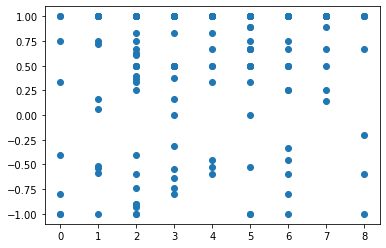

In [120]:
plt.scatter(result[-1], result[0])

In [18]:
for p, c, s, d in zip(preds, confs, scores, dev_cms):
    if (s>=0):
        continue
    print(d[0])
    print(p)
    print(c)
    print(s)
    print()

find Path \(-name Regex -or -name Regex \)
['find Path -regex Regex -print', 'find Path -regex Regex', 'find Path -regextype posix-extended -regex Regex', 'find Path -regextype posix-egrep -regex Regex', 'find Path | grep -E Regex']
[1.0, 1.0, 1.0, 1.0, 1.0]
-0.35

echo Regex | sed Program
['echo Regex', 'dirname $(dirname Regex)', 'echo Regex | tr -d Regex', 'echo Regex | awk Program', 'dirname -- Regex']
[1.0, 1.0, 1.0, 1.0, 1.0]
-0.4

sed Program File
['sed -i Program File', 'awk Program Program', 'sed -n Program', 'awk Program Program Program', 'awk -v Program -v Program Program Program']
[1.0, 1.0, 1.0, 1.0, 1.0]
-0.6

cat File File File | sort | comm -2 -3 File File
['comm -1 -3 <(sort File) <(sort File)', 'comm -2 -3 <(sort File) <(sort File) | grep -v Regex', 'comm -3 File File | comm -3 File File | comm -3 File File', 'comm -2 -3 <(sort File) <(sort File)', 'comm -2 -3 <(sort File) <(sort File) <(sort File)']
[1.0, 1.0, 1.0, 1.0, 1.0]
-0.5333333333333333

echo Regex | cat File

In [33]:
fullscores = [get_template_score(cm[0], pred, [1 for x in pred]) for pred, cm in zip(preds, dev_cms)]

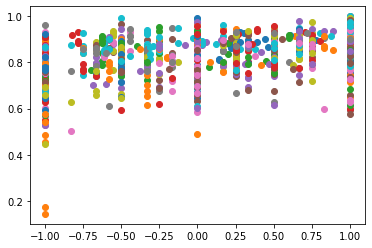

In [35]:
for x, y in zip(fullscores, confs):
    plt.scatter(x, y)

[DEBUG]: TM score 0.5987222222222222
[DEBUG]: BLUE score 0.7075061571934572
0.5987222222222222


(-1.0, 1.0)

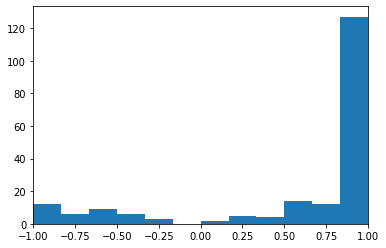

In [12]:
scores_old, preds_old = validate(mod_m, mod_m, tok_m, tok_m, dev_nls, dev_cms, overconfident=True)
plt.hist(scores_old, bins='auto')
print(np.mean(scores_old))
plt.xlim((-1, 1))

[DEBUG]: TM score 0.5983156746031746
[DEBUG]: BLUE score 0.6859032875576614
0.5983156746031746


(-1.0, 1.0)

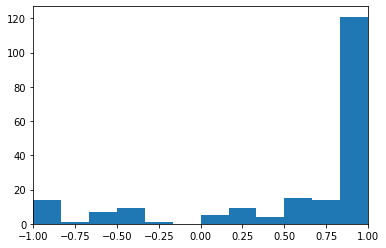

In [40]:
scores_overconf, preds_overconf = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
plt.hist(scores_overconf, bins='auto')
print(np.mean(scores_overconf))
plt.xlim((-1, 1))

[DEBUG]: TM score 0.577224859744878
[DEBUG]: BLUE score 0.6859032875576614
0.577224859744878


(-1.0, 1.0)

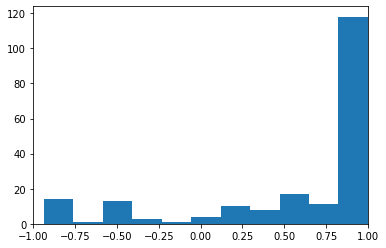

In [41]:
scores, preds = validate(model, tokenizer, dev_nls, dev_cms)
plt.hist(scores, bins='auto')
print(np.mean(scores))
plt.xlim((-1, 1))

In [42]:
scores_beams = []
for i in range(5, 11):
    set_cfg('beams', i)
    s, _ = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
    s = np.mean(s)
    print(f"{i} beams, score: {s}")
    scores_beams.append(s)

[DEBUG]: TM score 0.5983156746031746
[DEBUG]: BLUE score 0.6859032875576614
5 beams, score: 0.5983156746031746
[DEBUG]: TM score 0.5966142857142858
[DEBUG]: BLUE score 0.6859032875576614
6 beams, score: 0.5966142857142858
[DEBUG]: TM score 0.5959476190476191
[DEBUG]: BLUE score 0.6859032875576614
7 beams, score: 0.5959476190476191
[DEBUG]: TM score 0.6014476190476191
[DEBUG]: BLUE score 0.6859032875576614
8 beams, score: 0.6014476190476191
[DEBUG]: TM score 0.6017809523809524
[DEBUG]: BLUE score 0.6859032875576614
9 beams, score: 0.6017809523809524
[DEBUG]: TM score 0.5952809523809524
[DEBUG]: BLUE score 0.6859032875576614
10 beams, score: 0.5952809523809524


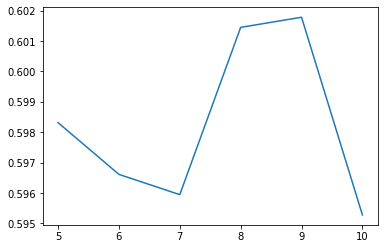

In [43]:
plt.plot(range(5,11), scores_beams)

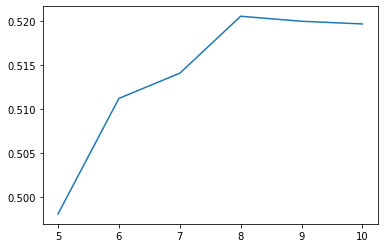

In [54]:
plt.plot(range(5,11), scores_beams)

In [67]:
score_pcon = [max(0,x) for x in scores_overconf]
np.mean(score_pcon)

0.6548159722222223

# diverse beam search

In [7]:
importlib.reload(mbs)

def encode(prompt):
    return f"{cfg('eos')} {cfg('sep1')} {prompt}\n{cfg('sep2')}"


def decode(tokenizer, v):
    text = tokenizer.decode(v, clean_up_tokenization_spaces=False)
    # remove query at the start
    start = text.find(cfg('sep2')) + len(cfg('sep2'))
    text = text[start:]
    # remove possible junk at the end
    end = text.find("\n")
    if end!=-1:
        text = text[:end]
    text = text.strip('\n ')
    return text


def decode_batch(tokenizer, vs):
    return [decode(tokenizer, v) for v in vs]

def tokenize_query(tokenizer, prompt):
    prompt = encode(prompt)
    encoded_prompt = tokenizer.encode(prompt, return_tensors="pt")
    return encoded_prompt.to(cfg('device'))


def predict_single_div(model, tokenizer, prompt, top=1, max_length=None, beams=None):
    prompt = tokenize_query(tokenizer, prompt)
    
    PreTrainedModel._generate_beam_search = mbs._generate_beam_search
    output = model.generate(
        input_ids=prompt,
        max_length=200,
        num_beams=cfg('beams'),
        do_sample=False,
        num_return_sequences=top,
        pad_token_id=tokenizer.eos_token_id,
        #fp16 = True
        )
    output = decode_batch(tokenizer, output)

    return output, [1 for _ in output]

In [54]:
predict_single_div(model, tokenizer, "find all pdfs", top=5)

(['find Path -name Regex -print',
  'find Path -name Regex -print',
  'find Path -iname Regex',
  'find Path -iname Regex',
  'find Path -name Regex -print'],
 [1, 1, 1, 1, 1])

In [19]:
for i in range(1,6):
    set_cfg('val_n', i)
    scores, preds = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
    #plt.hist(scores, bins='auto')
    
    print(i, np.mean(scores))
    #plt.xlim((-1, 1))

[DEBUG]: TM score 0.3736130952380952
[DEBUG]: BLUE score 0.7075061571934572
1 0.3736130952380952


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

[DEBUG]: TM score 0.47152976190476187
[DEBUG]: BLUE score 0.7075061571934572
2 0.47152976190476187
[DEBUG]: TM score 0.5409332010582011
[DEBUG]: BLUE score 0.7075061571934572
3 0.5409332010582011
[DEBUG]: TM score 0.5665128968253968
[DEBUG]: BLUE score 0.7075061571934572
4 0.5665128968253968
[DEBUG]: TM score 0.5987222222222222
[DEBUG]: BLUE score 0.7075061571934572
5 0.5987222222222222


In [21]:
set_cfg('val_n', 5)
scores_med1, preds_med1 = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
#plt.hist(scores, bins='auto')
    
print(i, np.mean(scores_med1))
#plt.xlim((-1, 1))

[DEBUG]: TM score 0.5987222222222222
[DEBUG]: BLUE score 0.7075061571934572
5 0.5987222222222222


In [24]:
set_cfg('val_n', 5)
scores_large1, preds_large1 = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
#plt.hist(scores, bins='auto')
    
print(i, np.mean(scores_large1))

[DEBUG]: TM score 0.5983156746031746
[DEBUG]: BLUE score 0.6859032875576614
5 0.5983156746031746


In [30]:
set_cfg('val_n', 5)
scores_large2, preds_large2 = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True)
#plt.hist(scores, bins='auto')
    
print(i, np.mean(scores_large2))

[DEBUG]: TM score 0.5963123015873016
[DEBUG]: BLUE score 0.6965600759927517
5 0.5963123015873016


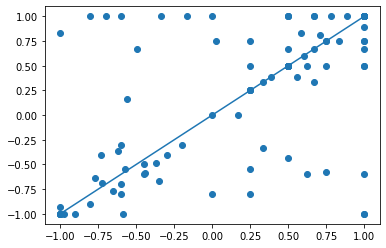

In [32]:
plt.scatter(scores_large2, scores_med1)
plt.plot((-1, 1), (-1, 1))

[DEBUG]: TM score 0.35923045634920636
[DEBUG]: BLUE score 0.6490820013846478
0.35923045634920636


(-1.0, 1.0)

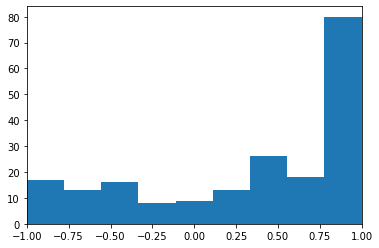

In [56]:
# DIV STRENGTH
# 3: 32.9
# 2: 41.6
# 1: 37.2

set_cfg('beams', 6)
scores, preds = validate(model, tokenizer, dev_nls, dev_cms, overconfident=True, div=True)
plt.hist(scores, bins='auto')
print(np.mean(scores))
plt.xlim((-1, 1))